## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your __goal is to learn a model of traffic count as a function of spatial location__.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the __logarithm__ of the traffic counts, and then __subtract the mean__ of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (__WhiteKernel__) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than __two standard deviations__ higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [415]:
Data1['traffic_count_transformed'] = np.log(Data1.AvgDailyTrafficCount) - np.mean(np.log(Data1.AvgDailyTrafficCount))
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,traffic_count_transformed
0,-80.278366,40.468606,84.0,-3.977526
1,-80.162117,40.384598,95.0,-3.854466
2,-80.221205,40.366778,97.0,-3.833632
3,-80.142455,40.622084,111.0,-3.698812
4,-80.131975,40.544915,125.0,-3.580029


In [416]:
# your code here
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

kernel = 1.* RBF(length_scale=(1.,1.)) \
    + WhiteKernel(noise_level=1.) # parameters of RBF kernel: length_scale, (length_scale_range_min, length_scale_range_max)
gp = GaussianProcessRegressor(kernel=kernel, random_state=0)

# Fit to data using maximum likelihood estimation of the parameters
X = np.asarray(Data1.loc[:,['Longitude','Latitude']])
Y = np.asarray(Data1.traffic_count_transformed)
gp.fit(X, Y)

print(gp.log_marginal_likelihood_value_)
print(gp.kernel_)

-1364.4049929526495
0.658**2 * RBF(length_scale=[0.0326, 0.0395]) + WhiteKernel(noise_level=0.568)


In [417]:
h = .003  # step size in the mesh
xx, zz = np.meshgrid(np.arange(min(Data1.Longitude), max(Data1.Longitude), h),
                     np.arange(min(Data1.Latitude), max(Data1.Latitude), h))
length = xx.shape[0]*xx.shape[1]
mesh_grid = np.concatenate((xx.reshape(length,1), zz.reshape(length,1)), axis = 1).reshape(length, 2)
mesh_grid_predict = gp.predict(mesh_grid)

In [418]:
mesh_results = pd.DataFrame({'xx':xx.reshape(length,), 'zz': zz.reshape(length,), 'pred': gp.predict(mesh_grid)})

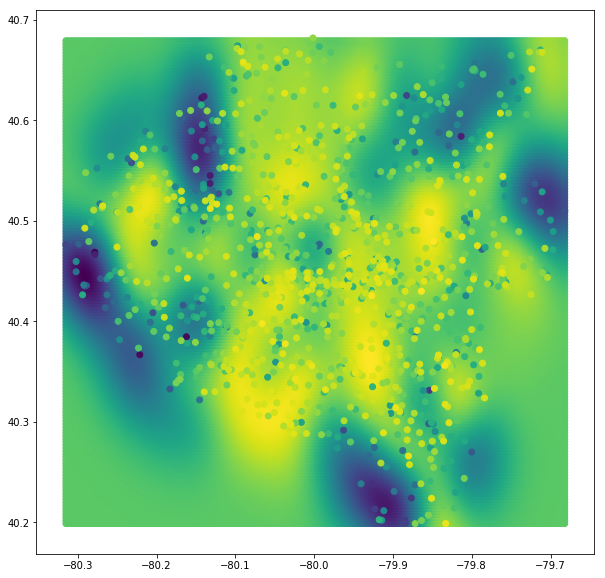

In [419]:
plt.figure(figsize=(10, 10))
plt.scatter(mesh_results.xx, mesh_results.zz, c = mesh_results.pred, edgecolors = 'face');
plt.scatter(Data1.Longitude, Data1.Latitude, c = Data1.traffic_count_transformed, edgecolors = 'face');

In [420]:
Y_pred, sigma = gp.predict(X, return_std=True)
pred_results = pd.DataFrame({'Y':Y, 'Y_pred': Y_pred, 'sigma' : sigma})

In [421]:
significance = list(map(lambda pred, actual, sigma: 
                        (pred > actual + 2*sigma) or (pred < actual - 2*sigma), 
                        pred_results.Y_pred, pred_results.Y, pred_results.sigma))

In [422]:
sum(significance) / len(significance)

0.042152466367713005

About 4% of the points are two stand diviation away from the actual value.

In [423]:
def find_interval(pred, actual, sigma):
    if pred > actual + 2*sigma:
        return 'r' #higher
    elif pred < actual - 2*sigma: 
        return 'g'#lower
    else:
        return 'b' #within

In [424]:
pred_results['significance'] = list(map(find_interval, pred_results.Y_pred, pred_results.Y, pred_results.sigma))

In [431]:
r = pred_results[pred_results.significance == 'r'].index
g = pred_results[pred_results.significance == 'g'].index
b = pred_results[pred_results.significance == 'b'].index

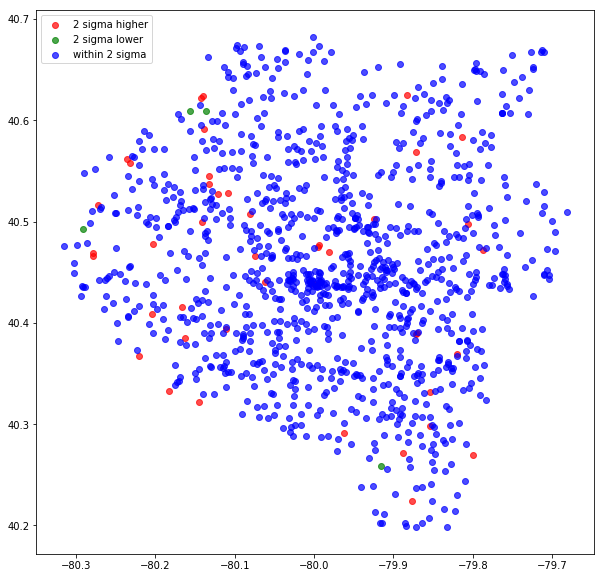

In [435]:
plt.figure(figsize=(10, 10))
plt.scatter(Data1.loc[r,'Longitude'], Data1.loc[r,'Latitude'], c = 'r', edgecolors = 'face', alpha = 0.7, label = '2 sigma higher');
plt.scatter(Data1.loc[g,'Longitude'], Data1.loc[g,'Latitude'], c = 'g', edgecolors = 'face', alpha = 0.7, label = '2 sigma lower');
plt.scatter(Data1.loc[b,'Longitude'], Data1.loc[b,'Latitude'], c = 'b', edgecolors = 'face', alpha = 0.7, label = 'within 2 sigma');
plt.legend();

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly 


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


+ A: __Anomaly__, since (1,0) is 2 standard deviation away from center (0,0) and there are relatively a lot of points, it is more likely to be an anomaly. 
+ B: __Not anomaly__, since point is within 2 standard deviation away from center and there are a lot of points, hence it is more likely to not be an anomaly. 
+ C: __Anomaly__, even though point is within 2 standard deviation away from center, there are relatively few points, therefore it is likely to be an anomaly. 
+ D: __Not anomaly__, the point is within 2 standard deviation way from the center, and there are relatively a lot of points, hence it is more likely to mot be an aomaly. 

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [436]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [437]:
col = ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]
df = Data2[col]

In [438]:
df = df.replace('?', np.nan).dropna(axis = 0)

In [439]:
for el in col:
    df[el] = pd.cut(pd.to_numeric(df[el]), 5, labels=[0,1,2,3,4])
df.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,1,2,0,1,1,3
1,1,2,0,1,1,3
2,2,4,0,2,3,3
3,2,4,0,1,2,3
4,1,2,0,1,1,3


In [440]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ExhaustiveSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import MaximumLikelihoodEstimator

In [457]:
np.random.seed(10)
hc = HillClimbSearch(df, scoring_method=BicScore(df))
best_model = hc.estimate()
print(best_model.edges())

model = BayesianModel(best_model.edges())
model.fit(df, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

[("'\\% Smokers'", "'Average Daily PM2.5'"), ("'\\% Smokers'", "'\\% Obese'"), ("'\\% Children in Poverty'", "'Violent Crime Rate'"), ("'\\% Children in Poverty'", "'80/20 Income Ratio'"), ("'\\% Children in Poverty'", "'\\% Smokers'")]
CPD of '80/20 Income Ratio':
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '\% Children in Poverty' | '\% Children in Poverty'(0) | '\% Children in Poverty'(1) | '\% Children in Poverty'(2) | '\% Children in Poverty'(3) | '\% Children in Poverty'(4) |
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '80/20 Income Ratio'(0)  | 0.41690962099125367         | 0.18263473053892215         | 0.04792332268370607         | 0.016835016835016835        | 0.0                         |
+-----------------

In [458]:
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print thevariable,theparents,theprob
        loglike += np.log(theprob)
    return loglike

In [459]:
exmp=df.apply(lambda x: LL(x,model),axis = 1)

In [460]:
bayesian_df = Data2[['County']]
bayesian_df['ll'] = exmp
bayesian_df.sort_values(by = ['ll']).head(5)

/nfshome/bc1561/.conda/envs/mlc/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,County,ll
1856,"New York, New York",-15.242954
1227,"Suffolk, Massachusetts",-15.218920
221,"San Francisco, California",-15.209478
317,"District of Columbia, District of Columbia",-13.826869
2027,"Rolette, North Dakota",-13.794734


## Kmeans Anomaly Detection

In [445]:
from sklearn.cluster import KMeans

np.random.seed(1)
km = KMeans(n_clusters=3).fit(df)
labels = km.predict(df)
centroids = km.cluster_centers_

In [446]:
km_df = pd.DataFrame(df.index)
km_df['labels'] = labels

In [447]:
dist_mtx = pd.DataFrame(km.transform(df), columns = ['0', '1', '2'])

In [448]:
km_df['dist_from_center'] = list(map(lambda x,y,z: min(x,y,z), dist_mtx['1'], dist_mtx['2'], dist_mtx['0']))

In [449]:
Data2.loc[km_df.nlargest(5, 'dist_from_center').index, 'County']

2592              Erath, Texas
1870    St. Lawrence, New York
1706       Lancaster, Nebraska
2253     Cameron, Pennsylvania
2372        Clay, South Dakota
Name: County, dtype: object

## Gaussian Mixture Anomaly Detection

In [450]:
from sklearn.mixture import GaussianMixture

In [451]:
gm = GaussianMixture(3, random_state=0).fit(df)
labels1 = gm.predict(df)

In [452]:
gm_df = pd.DataFrame(df.index)
gm_df['labels'] = labels1
gm_df['score'] = gm.score_samples(df)

In [453]:
Data2.loc[gm_df.nsmallest(5, 'score').index, 'County']

1870    St. Lawrence, New York
1873       Schoharie, New York
2592              Erath, Texas
1142     Livingston, Louisiana
1826          Albany, New York
Name: County, dtype: object

## Isolation Forest Anomaly Detection

In [454]:
from sklearn.ensemble import IsolationForest

X = df
clf = IsolationForest(max_samples=100, random_state=3)
clf.fit(X)
y_pred = clf.predict(X)
if_score = clf.decision_function(X)

In [455]:
if_df = pd.DataFrame(df.index)
if_df['score'] = if_score
if_df['anomaly'] = y_pred

In [456]:
Data2.loc[if_df.nsmallest(5, 'score').index, 'County']

2253      Cameron, Pennsylvania
1059          Lincoln, Kentucky
23              Dallas, Alabama
2244    Armstrong, Pennsylvania
1870     St. Lawrence, New York
Name: County, dtype: object

## Conclusion: 
From the 3 clustering results, we observed some overlaps between different techniques. 
+ St.Lawrence appeared in all 3 
+ Erath appeared in both kmeans and gaussain mixture
+ Cameron appeared in both Isolation Forest and kmeans 
However, we do not observe overlaps between the clustering results and bayesian network results.
The difference occurs because different classification techniques has their own corresponding properties, Kmeans tend to form circular clusters, while gaussian mixture does not. Isolation forest is a set of decision trees that chooses anomaly based on tree depth. Bayesian network counts the loglikelihood of each data point of taking place, which takes in the relations between different features into account. 